"""

So it is fairly common to do intrapixel correction in photometry. This is merely a correction for the fact that pixel is not uniformly sensitive and so there will be more (or less) light depending on where on the pixel it falls. This is a simple correction normally, but with BRITE unfortunately it's a lot more difficult. What we are going to correct here is hard to describe. Since BRITE is not cooled the PSF of the star changes with temperature. That means that where the light falls on the pixel also changes with temperature and not just with PSFs position. So simple intrapixel corrections don't work because the correction will change with temperature. We are going to take you through the correction step by step.

Again we will import necessary modules and functions

In [1]:
import numpy as np

import scipy.interpolate as scInterp

import matplotlib.pyplot as plt

import statsmodels.api as sm

#BRITE routine
from BRITE_decor.inout import load_alt as load
from BRITE_decor.analysis import extra as be
import BRITE_decor.inout.OUTdetrendTempPSF as savePSFdetrendBRITE

import BRITE_decor.detrending.detrendTempPSF as PSFdetrendBRITE
import BRITE_decor.detrending.binningWtemperature as TEMPbinBRITE

import BRITE_decor.plotting.PLOTbinningWtemperature as plotTEMPbinBRITE
#enable inline plots
%matplotlib inline

Like in the first tutorial, we need to load our data. This time our helper function won't create the file name for us, so we'll have to define our filename



In [11]:
filename = 'example_data/HD37043_OrionI-2013_UBr_setup7_orem_edit.dat'

data,  columns, params = load.load_dataset(filename)

show_ME = False # show all plots (not practical for the notebook)
orbper = float(params['orbper'])

xPOS = data[:,columns['XCEN']]
FLUX = data[:,columns['FLUX']]
FLUX = (FLUX-np.mean(FLUX))/np.mean(FLUX)*1e3
data[:,columns['FLUX']] =FLUX


Alright, we have our data, but probably not a very good understanding of what we are trying to correct or why it is necessary. Additionally, we want to change the flux so that the values are not so large which can influence fitting. In our case we have changed to differential flux in ppt.  Also, a plot will better explain what is happening. 

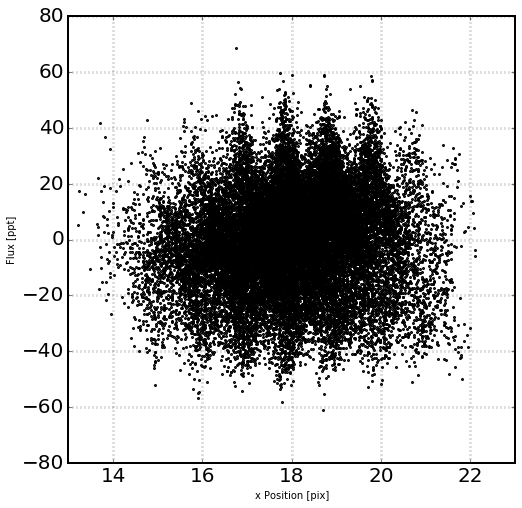

In [12]:
plt.figure(figsize=(8,8))
plt.plot(xPOS, FLUX, 'k.', ms=2)
plt.xlabel('x Position [pix]')
plt.ylabel('Flux [ppt]')
plt.grid(color='k', lw=3, alpha=.25)

plt.show()

In this figure you can see what appears to be a very noisy sinusoidal pattern with a period of about 1 pixel? This is our intrapixel variation. But, this was already corrected for, before the data even got to us, so why do we still see it? Well, let's plot a phased diagram of this data and we'll see why. The easiest way to do this in python is just to take the number after the decimal which can be done with %1.


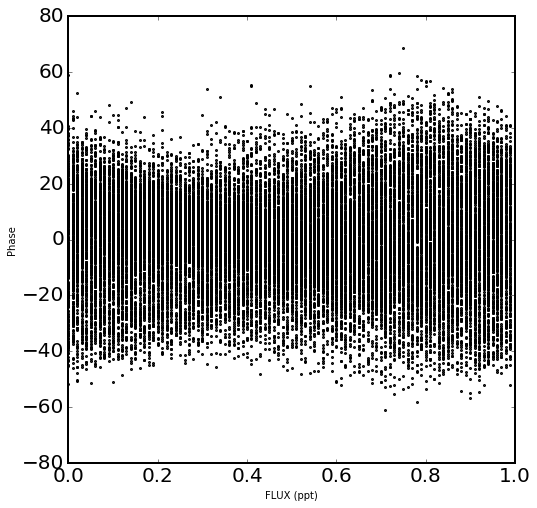

In [13]:
plt.figure(figsize=(8,8))
plt.plot(xPOS%1, FLUX, 'k.', ms=2)
plt.xlabel('FLUX (ppt)')
plt.ylabel('Phase')
plt.show()


There doesn't look to be anything in the phase folded data, but we can SEE it in the non-phase folded data, so what is the issue? Well you remember how earlier I said that the variation changes with temperature? That is our problem. To emphasize this, let's plot only the data below and above a certain temperature.



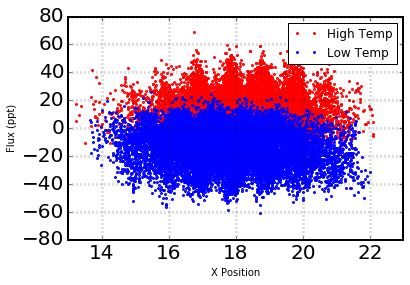

In [14]:
temp = data[:,columns['CCDT']]
med_temp = np.median(temp)
plt.figure()

plt.plot(xPOS[temp > med_temp], FLUX[temp > med_temp], 'r.', ms=2, label='High Temp')
plt.plot(xPOS[temp < med_temp], FLUX[temp < med_temp], 'b.', ms=2, label='Low Temp')
plt.xlabel('X Position')
plt.ylabel('Flux (ppt)')
plt.grid(color='k', lw=3, alpha=.25)
plt.legend()
plt.show()

And here is our smoking gun. The variations LOOK similar, but it's pretty clear to see that the two datasets are out of phase. Therefore, it's impossible to do an intrapixel correction on the entire dataset, because phase folding cancels outhe effect. However, if we split the data first as a function of temperature, this correction becomes much easier to make. 

We have a fancy function that does essentially this, but it's complicated. so an overview is necessary. The function "TEMPbinBRITE" Brite does the following:

1.) fits a lowess filter to the long term trend of temperature with time. From this it determines when there has been a change in temperature larger than a certain amount "TEMPcrit". The default is 2.5 degrees. Note: The reason we use a lowess filter here is because the temperature will change in orbit 4-5 degrees and this will mess up our ability to bin in any coherent way.

2.) In addition to this, if there are large gaps in the data, it is likely something problematic happened and the data on either side of the gap should be considered differently. To take this into account you set 'GAPsinclude' to True (default is False) and set the size of gap  'GAPScrit' that will stop a bin (default is 0.3 days).


3.) Finally we want to make sure our binsize is not too small as that can also affect adversely affect the data so we allow for a minimum binsize BINminSIZE (default 1 day).

However, many of these are kwargs, which means they are not required inputs and defaults are in place (if necessary) when you do not specify them. All that is absolutely necessary are the temperature and time arrays. 


In [15]:
HJD = data[:,columns['HJD']]

However, there are a couple of kwargs that we should set. The main one is the lowess filter fraction we learned about in the first tutorial. We also learned a good value is for time vs. temperature is 0.06. While this isn't particularly good for outlier rejection, it should work fine for these purposes. However, if the function is too sharp it will cause problems, so to be on the safe side let's set our lowess fraction value to 0.1. 


In [16]:
frac = 0.1

Also, since the Orion I data has some very large gaps, we should take these into account in our function. The size of the gaps is a bit arbitrary, but 1 day seems like a reasonable value.


In [17]:
GAPSinclude = True
GAPScrit = 2.5

We don't have anymore insight right now, so let's run the function and see how well it works. And collect relevant information in the header.


In [18]:
binENDindexes, binENDindexes_reason, tempCCDLONG = TEMPbinBRITE.openTIMEwithTEMPERATURE(HJD, temp, GAPSinclude=GAPSinclude, GAPScrit=GAPScrit, LOWESSfrac=frac)


params['GAPSinclude'] = GAPSinclude
params['GAPScrit'] =GAPScrit
params['tempfrac'] = frac


	Performing lowess filtering ...
	... all done.

	Initialising complete...
	End of bin: Gap			index    657 (at time 2.244 d) with a binlength of 2.244 d.
		tdiff = 6.761d;		gapSIZE limit is 2.500d.
	End of bin: Gap			index   1290 (at time 10.199 d) with a binlength of 1.194 d.
		tdiff = 16.819d;		gapSIZE limit is 2.500d.
	End of bin: Gap			index   2715 (at time 29.876 d) with a binlength of 2.858 d.
		tdiff = 4.117d;		gapSIZE limit is 2.500d.
	End of bin: Gap			index   5375 (at time 43.823 d) with a binlength of 9.831 d.
		tdiff = 2.921d;		gapSIZE limit is 2.500d.
	End of bin: Gap			index   7380 (at time 53.243 d) with a binlength of 6.499 d.
		tdiff = 11.724d;		gapSIZE limit is 2.500d.
	End of bin: Temperature		index   8252 (at time 71.171 d) with a binlength of 6.203 d.
		Tdiff = -2.51deg;	dTEMP limit is +2.50deg.
	End of bin: Temperature		index  10475 (at time 78.423 d) with a binlength of 7.182 d.
		Tdiff = -2.52deg;	dTEMP limit is +2.50deg.
	End of bin: Temperature		index  11723 (

Now let's explain the output. binEndindexes is a long but descriptive name which essentially gives you the array index of the last element in for each of the chunks we have split our data into. binENDindexes_reason is mainly for bookkeeping. It tells us the reason the bin ended at the point, either because of the temperature change, or because it encountered a large gap. The final piece tempCCDLONG, is the lowess relation of the temperature as a function of time. It is returned, so that we can plot and make sure it looks as we expect. Speaking of which there is a convenience function which plots all the stuff you need to check how well your binning worked. This is surprisingly referred to as "PLOTopenTIMEwithTEMPERATURE". It takes all the outputs from before as well as the x position, yposition, time, and temperature and ... well let's just look at the output. It's easier that way. 

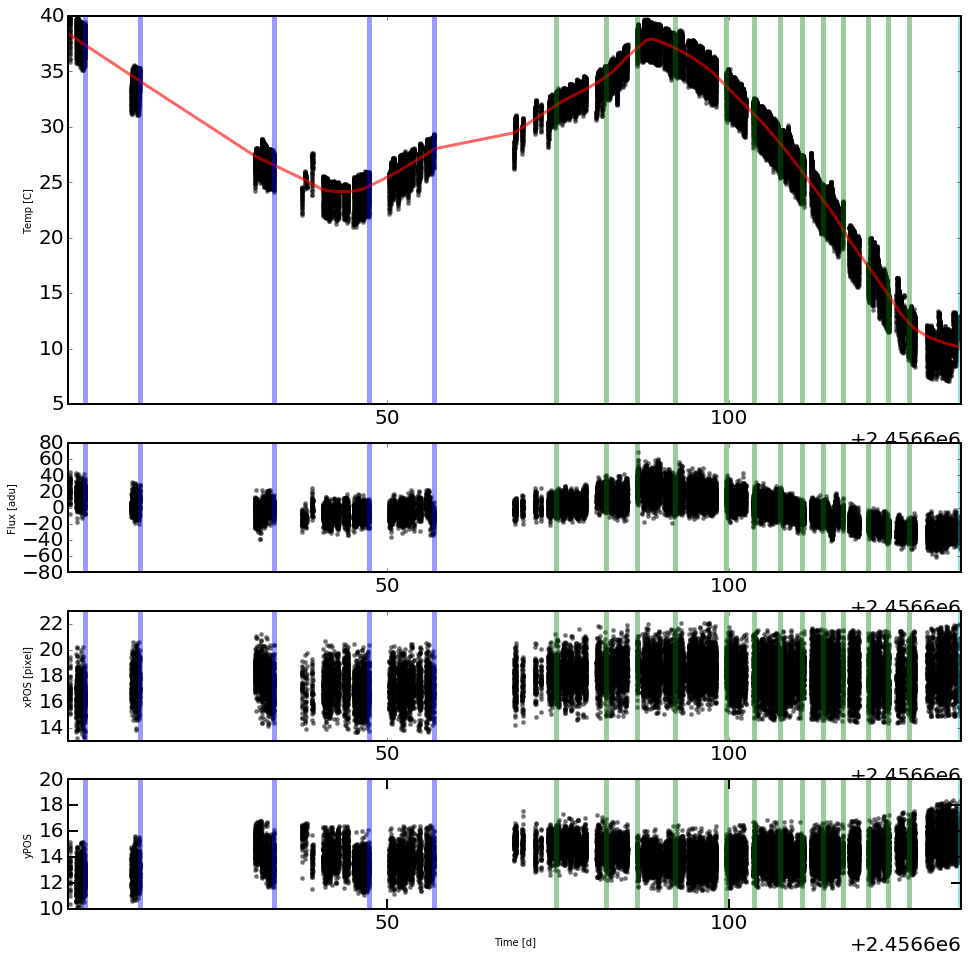

In [19]:
yPOS = data[:,columns['YCEN']]

plotTEMPbinBRITE.PLOTopenTIMEwithTEMPERATURE(HJD, FLUX, temp, tempCCDLONG, xPOS, yPOS, binENDindexes, binENDindexes_reason)
plt.show()



So, there's a lot of info here, but the heart of it is the top plot. It gives time vs. temperature (black), the lowess relation (red) and the endpoints of each data chunk and whether it was caused by gaps (blue) or temperature change (green). The bottom three plots just show how this data is broken up for Flux, x position and y position. At first glance it looks reasonable. It might even look better if you have used the temperature gui to remove outliers. Now though, we must see how well the decorrelation goes. From here you can develop your own decorrelation routine if you like, but we have a couple for you. First let's try a simple intrapixel removal routine on each data block. 

Note: IN this function plot=False by default. You can change it to True, but just be prepared for about 20 plots.


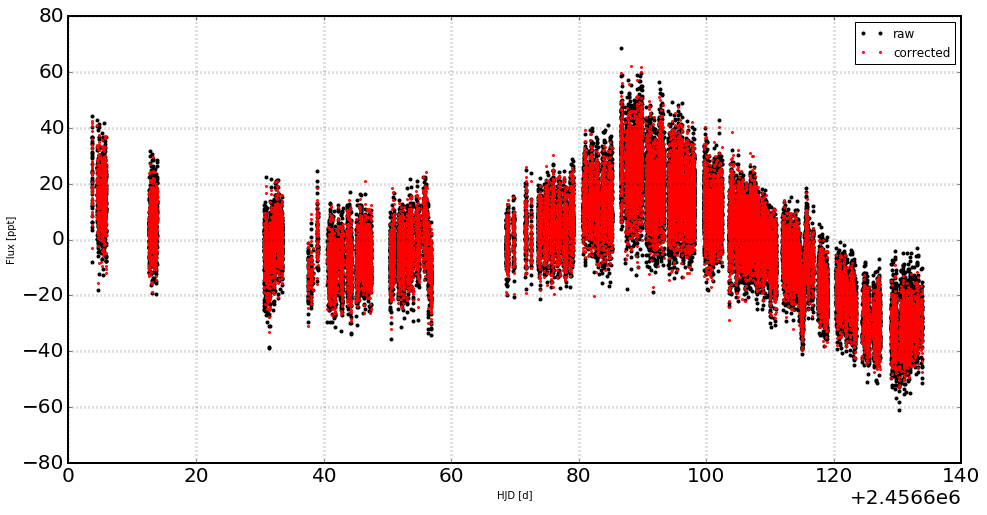

In [20]:
flux_intcorrected = be.binnedINTRAPIXEL(FLUX, xPOS, yPOS, binENDindexes, plot=show_ME)

plt.figure(figsize=(16,8))
plt.plot(HJD, FLUX, 'k.', ms=4, label='raw') 
plt.plot(HJD, flux_intcorrected, 'r.', ms=2, label='corrected') 
plt.xlabel('HJD [d]')
plt.ylabel('Flux [ppt]')
plt.grid(color='k', lw=3, alpha=.25)
plt.legend()
plt.show()


This does a reasonably good job and it does something no other routine does which is allow us to do x and y corrections simultaneously. However if there are significant slopes or changes in amplitude, this method can suffer as is clear if you plotted all of the different comparisons in BRITE_extra.binnedINTRAPIXEL.


If we want to take these variations into account, then we must 

1.) Fit the data
2.) treat X and Y separately

This time it will be slightly less convenient, but it will be for your own good.Instead, of having it loop over all the data internally, we are going to create our own for loop which slices the data into chunks and then fits each chunk.


In [31]:
init_ind = 0 # starting index

correction = [] # list to put corr
tckFIRSTstring = [] # list to place the 'tck's of the fit
tckSECONDstring = [] # list to place the 'tck's of the fit with the second coordinate
diagnostic = []  # additional diagnostic values from the routine
SPLINEstringLENGTH = 3000
SPLINEknotpointsSPACING = np.array([0.15, 0.17, 0.20, 0.22, 0.25, 0.3, 0.35])#, 0.4, 0.45, 0.50])
SPLINEorder = np.array([3], dtype='int32') #you need to specify the integer type because the fitting function is tempermental

params['SPLINEstringLENGTH'] = SPLINEstringLENGTH
params['SPLINEknotpointsSPACING'] = list(SPLINEknotpointsSPACING)
params['SPLINEorder'] = list(SPLINEorder)


THIS IS window 0


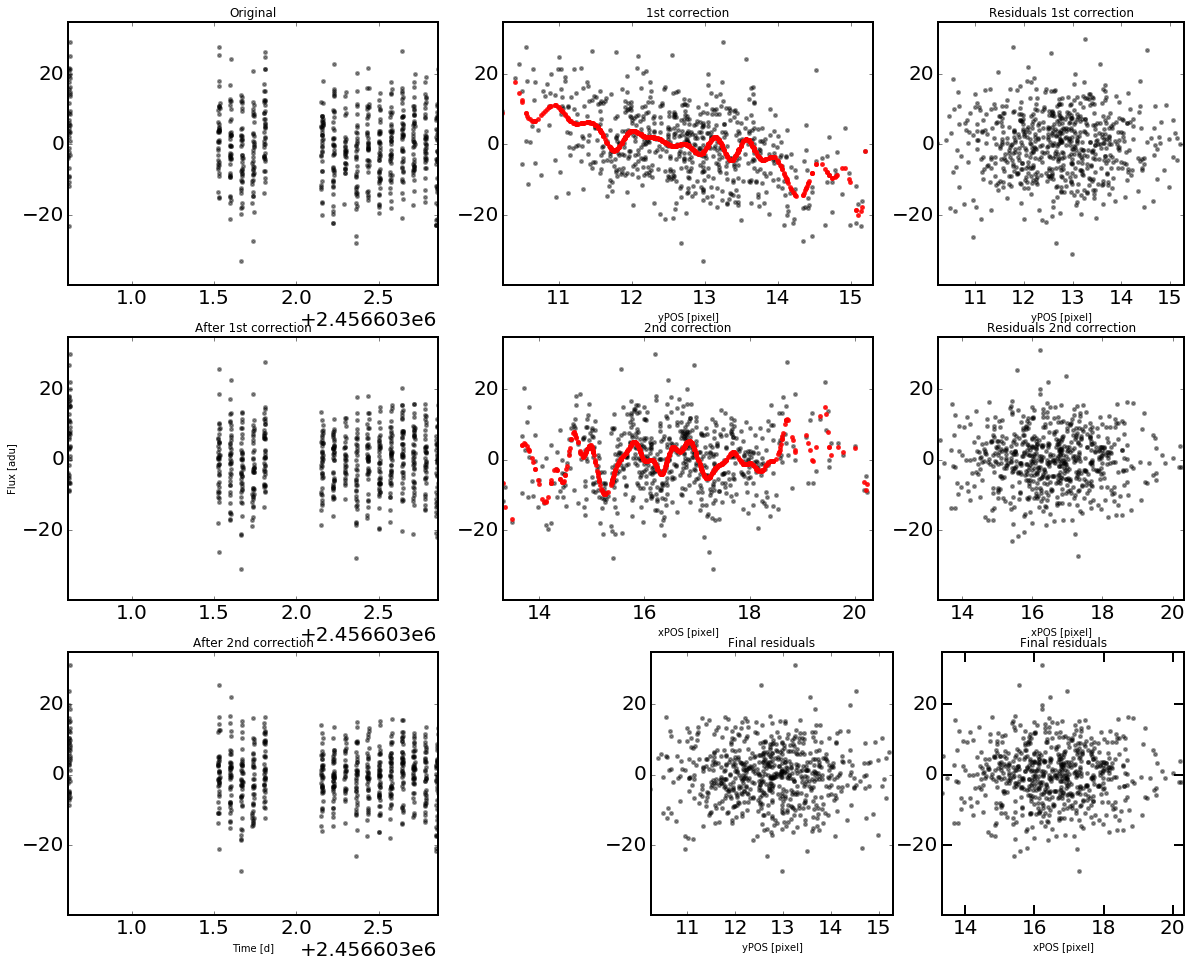

Minor debugging diagnostics provided for your convenience
1 - knotpoint spacing = 0.20; phaseshift spacing = 0.02
2 - knotpoint spacing = 0.17; phaseshift spacing = 0.06
THIS IS window 1


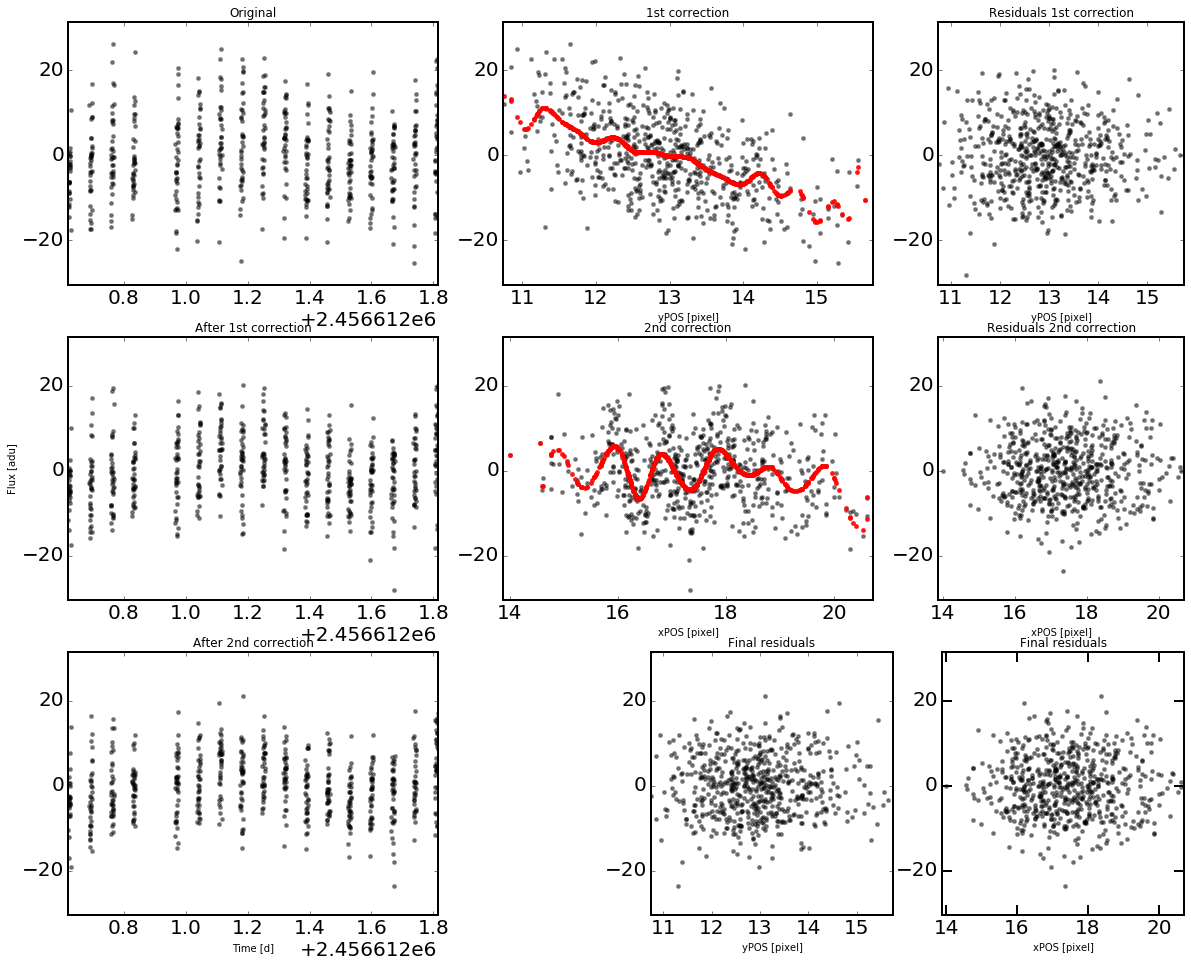

Minor debugging diagnostics provided for your convenience
1 - knotpoint spacing = 0.25; phaseshift spacing = 0.11
2 - knotpoint spacing = 0.35; phaseshift spacing = 0.16
THIS IS window 2


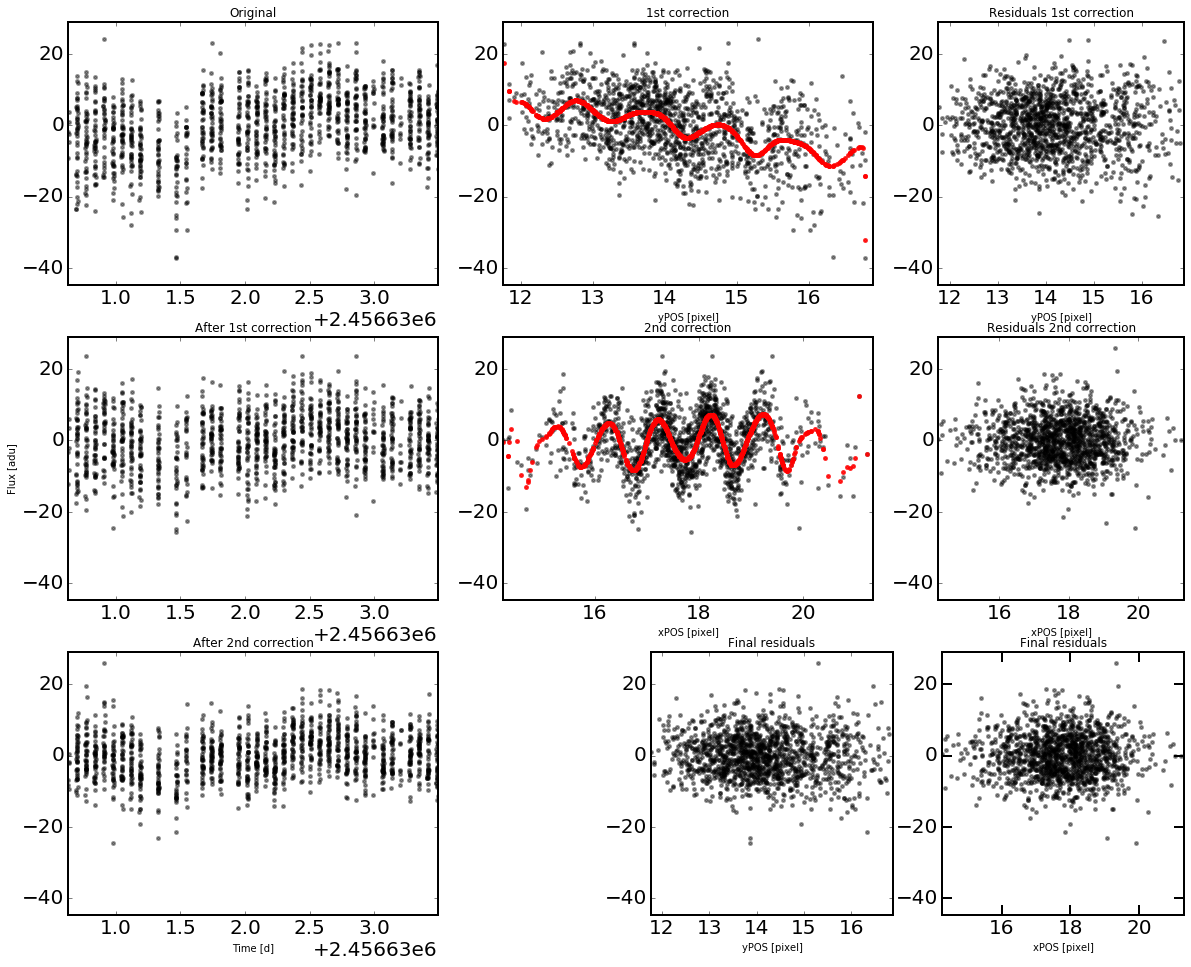

Minor debugging diagnostics provided for your convenience
1 - knotpoint spacing = 0.25; phaseshift spacing = 0.10
2 - knotpoint spacing = 0.22; phaseshift spacing = 0.03
THIS IS window 3


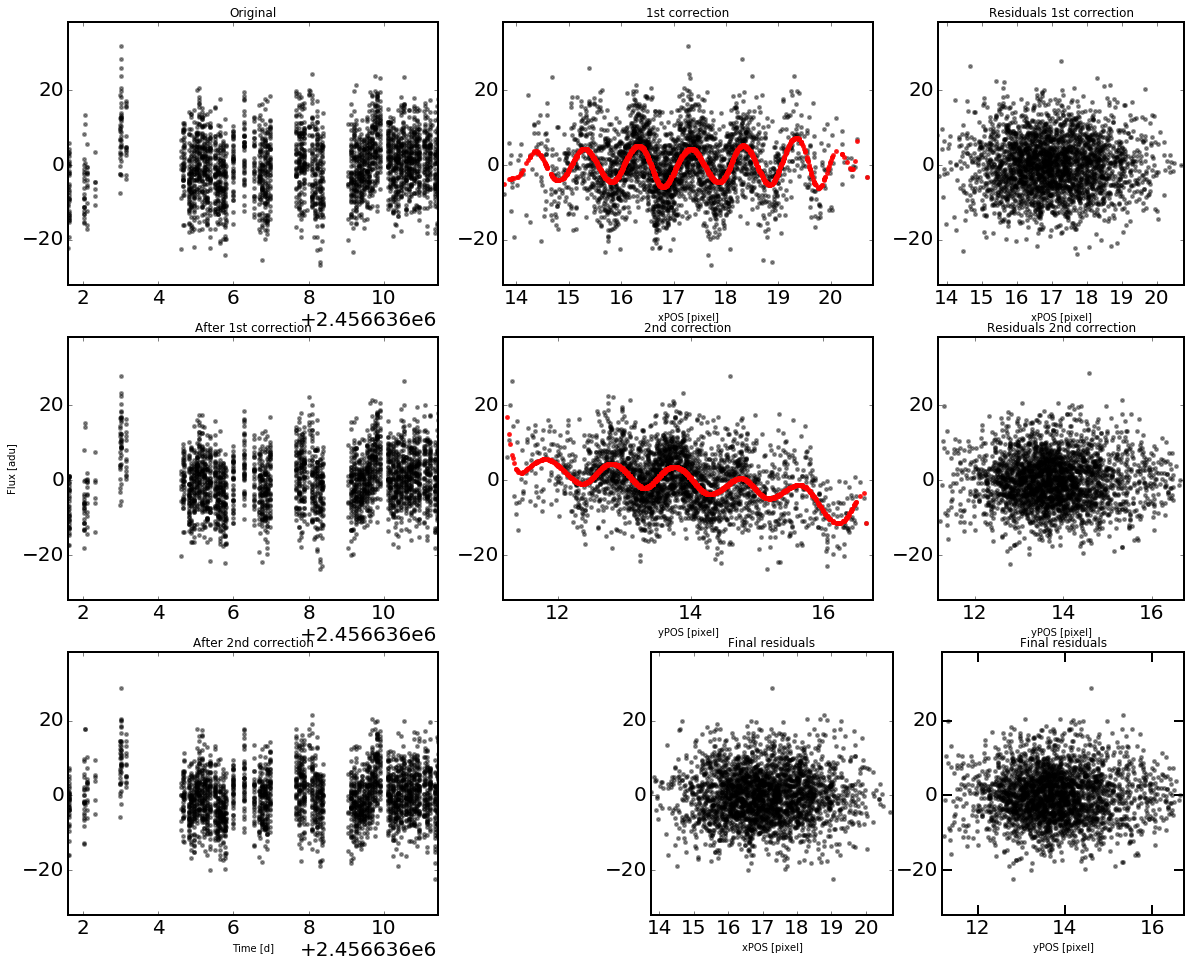

Minor debugging diagnostics provided for your convenience
1 - knotpoint spacing = 0.30; phaseshift spacing = 0.11
2 - knotpoint spacing = 0.30; phaseshift spacing = 0.13
THIS IS window 4


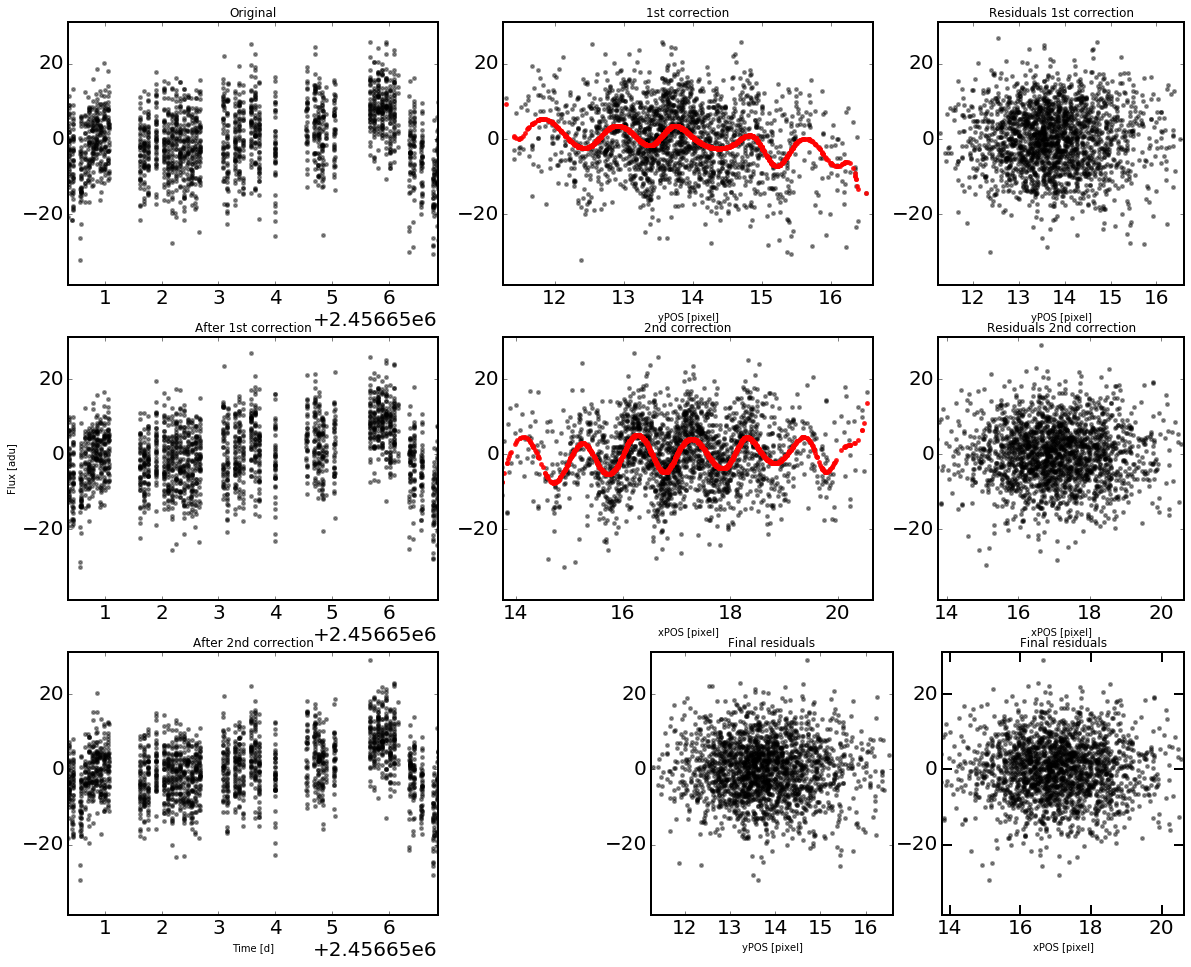

Minor debugging diagnostics provided for your convenience
1 - knotpoint spacing = 0.30; phaseshift spacing = 0.15
2 - knotpoint spacing = 0.30; phaseshift spacing = 0.10
THIS IS window 5


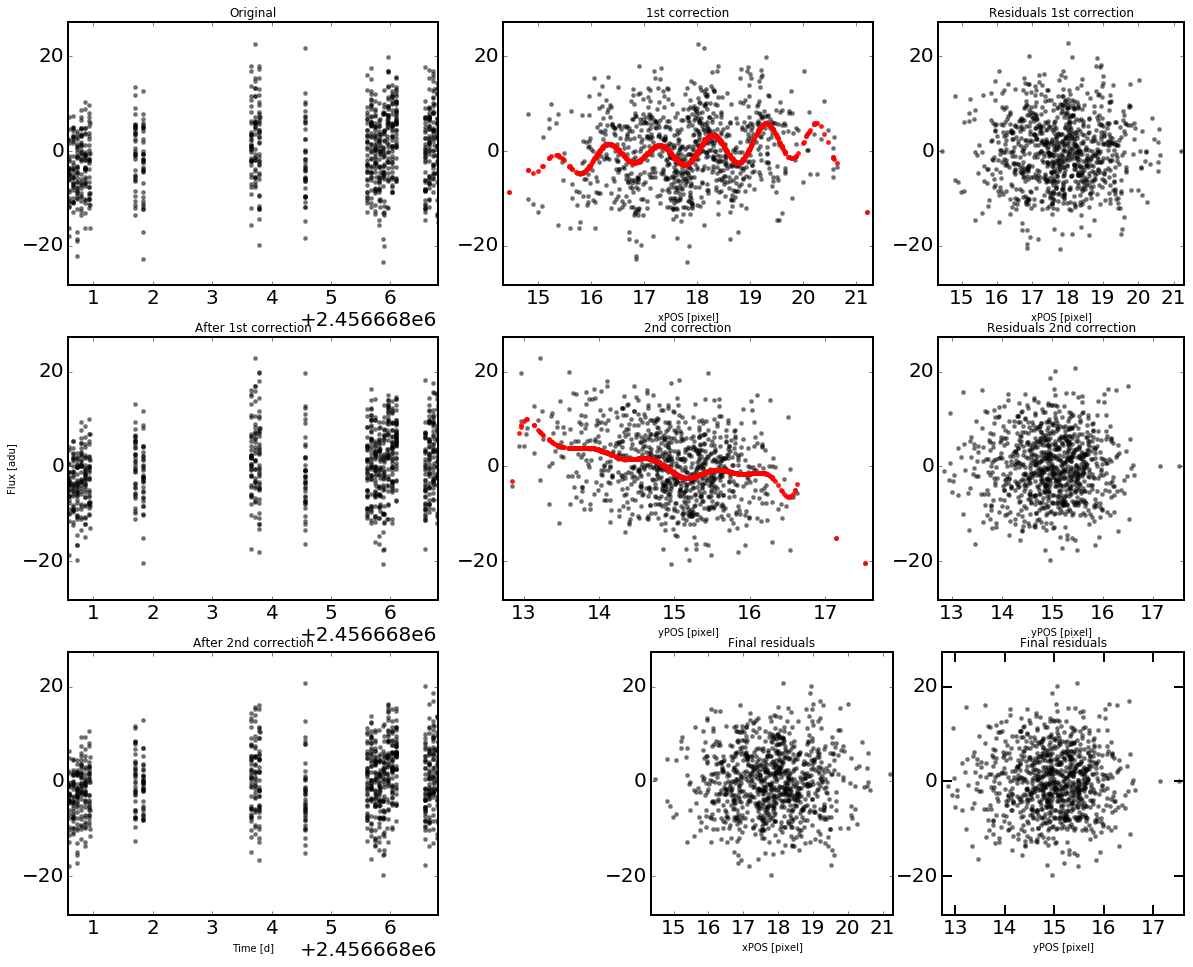

Minor debugging diagnostics provided for your convenience
1 - knotpoint spacing = 0.50; phaseshift spacing = 0.06
2 - knotpoint spacing = 0.40; phaseshift spacing = 0.10
THIS IS window 6


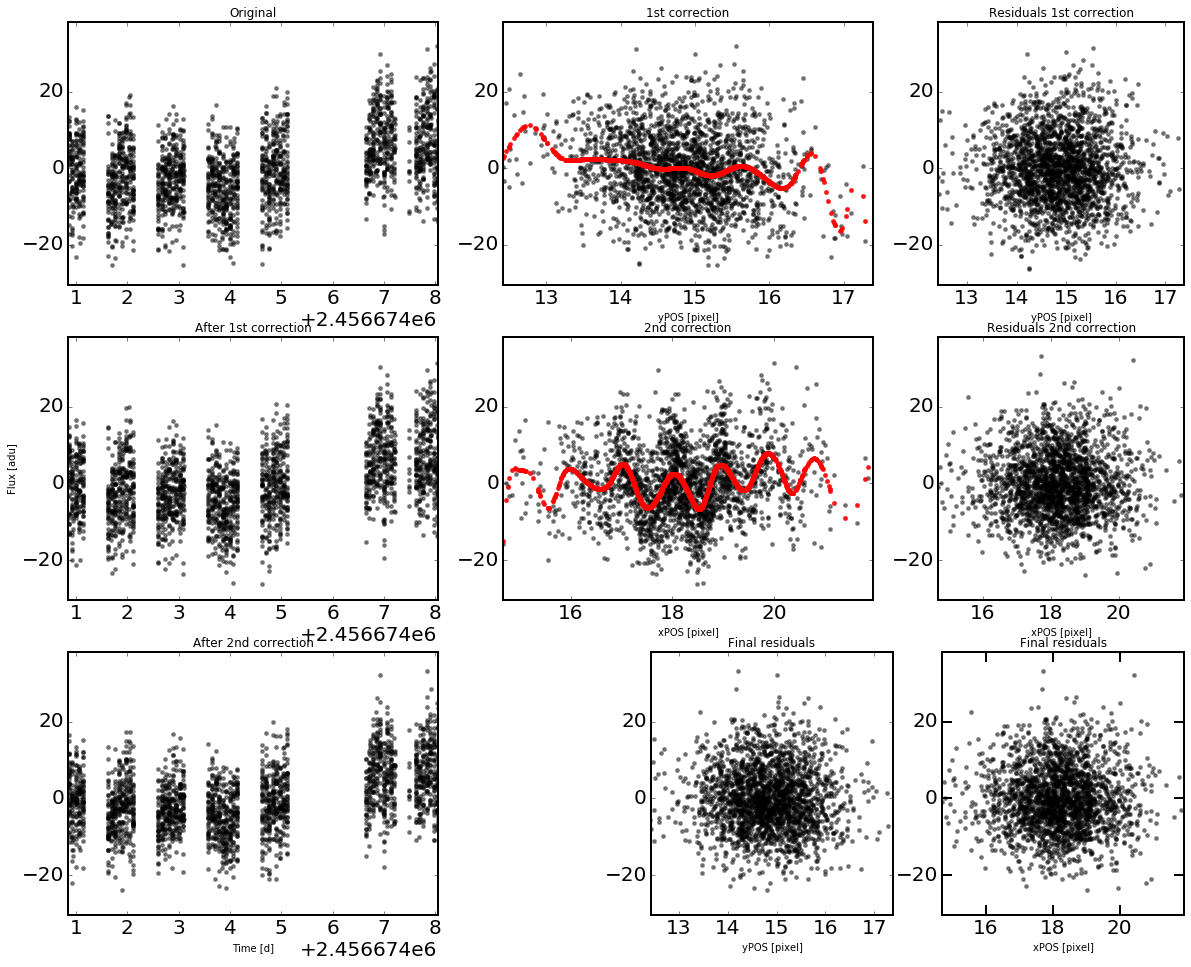

Minor debugging diagnostics provided for your convenience
1 - knotpoint spacing = 0.35; phaseshift spacing = 0.12
2 - knotpoint spacing = 0.30; phaseshift spacing = 0.08
THIS IS window 7


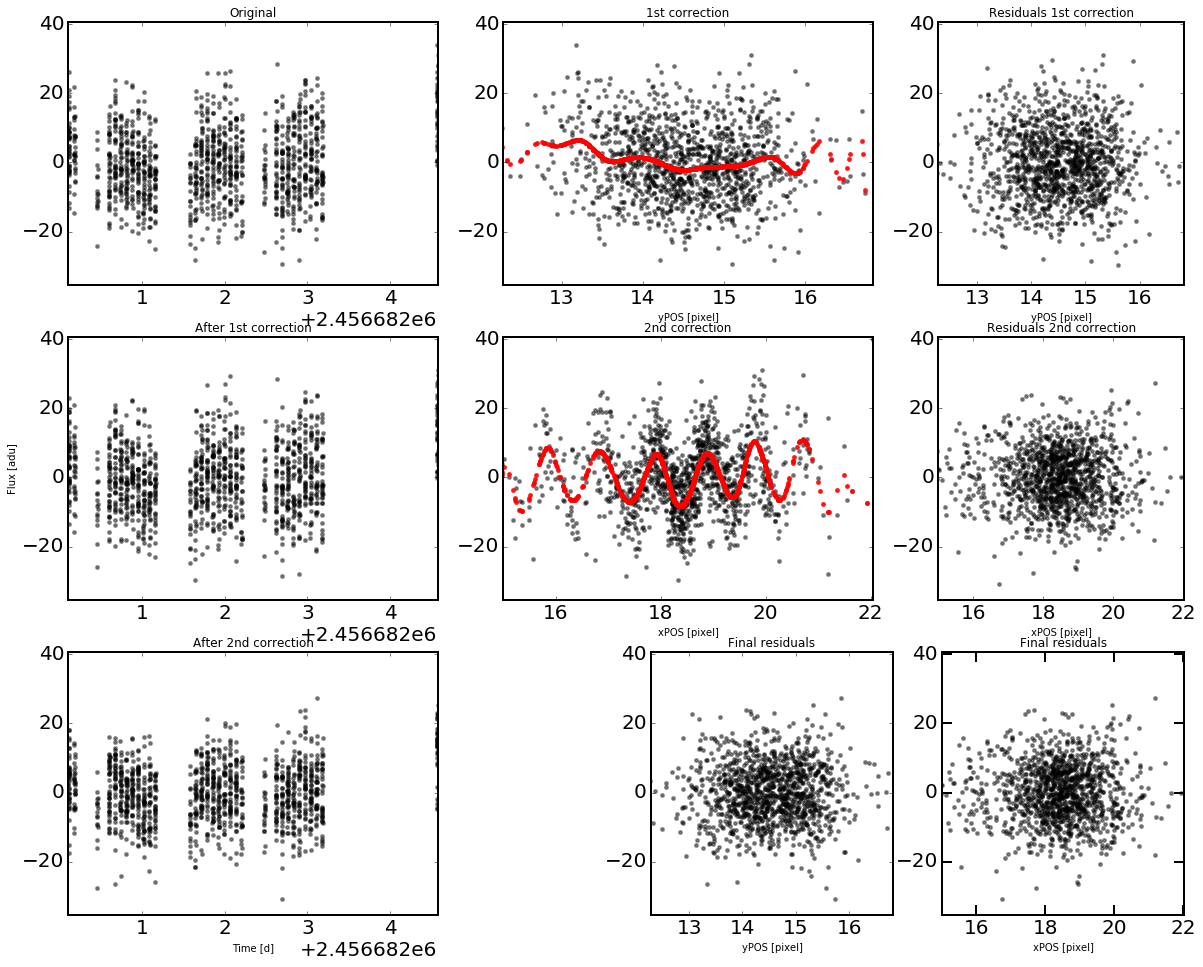

Minor debugging diagnostics provided for your convenience
1 - knotpoint spacing = 0.30; phaseshift spacing = 0.16
2 - knotpoint spacing = 0.30; phaseshift spacing = 0.05
THIS IS window 8


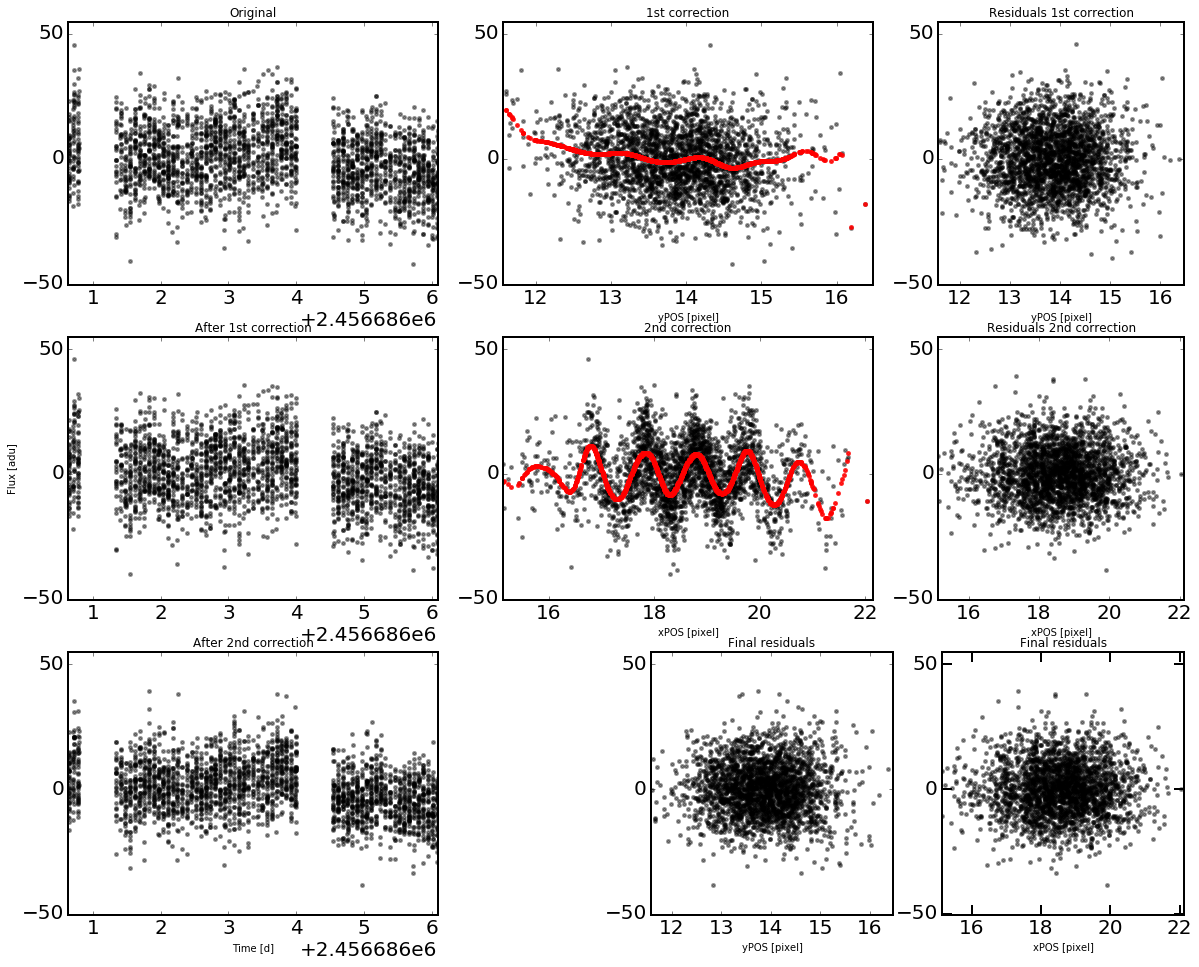

Minor debugging diagnostics provided for your convenience
1 - knotpoint spacing = 0.35; phaseshift spacing = 0.32
2 - knotpoint spacing = 0.30; phaseshift spacing = 0.23
THIS IS window 9


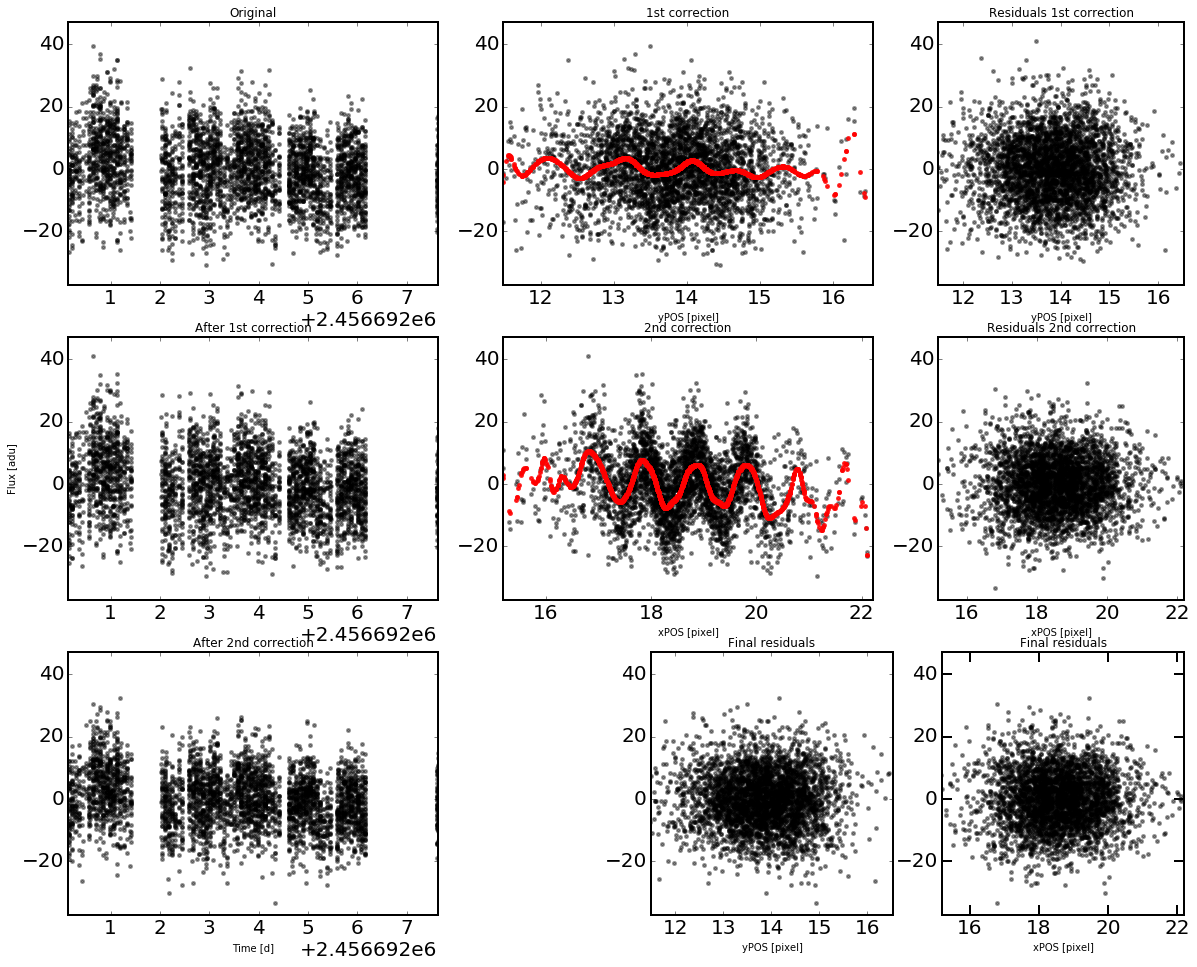

Minor debugging diagnostics provided for your convenience
1 - knotpoint spacing = 0.22; phaseshift spacing = 0.05
2 - knotpoint spacing = 0.15; phaseshift spacing = 0.14
THIS IS window 10


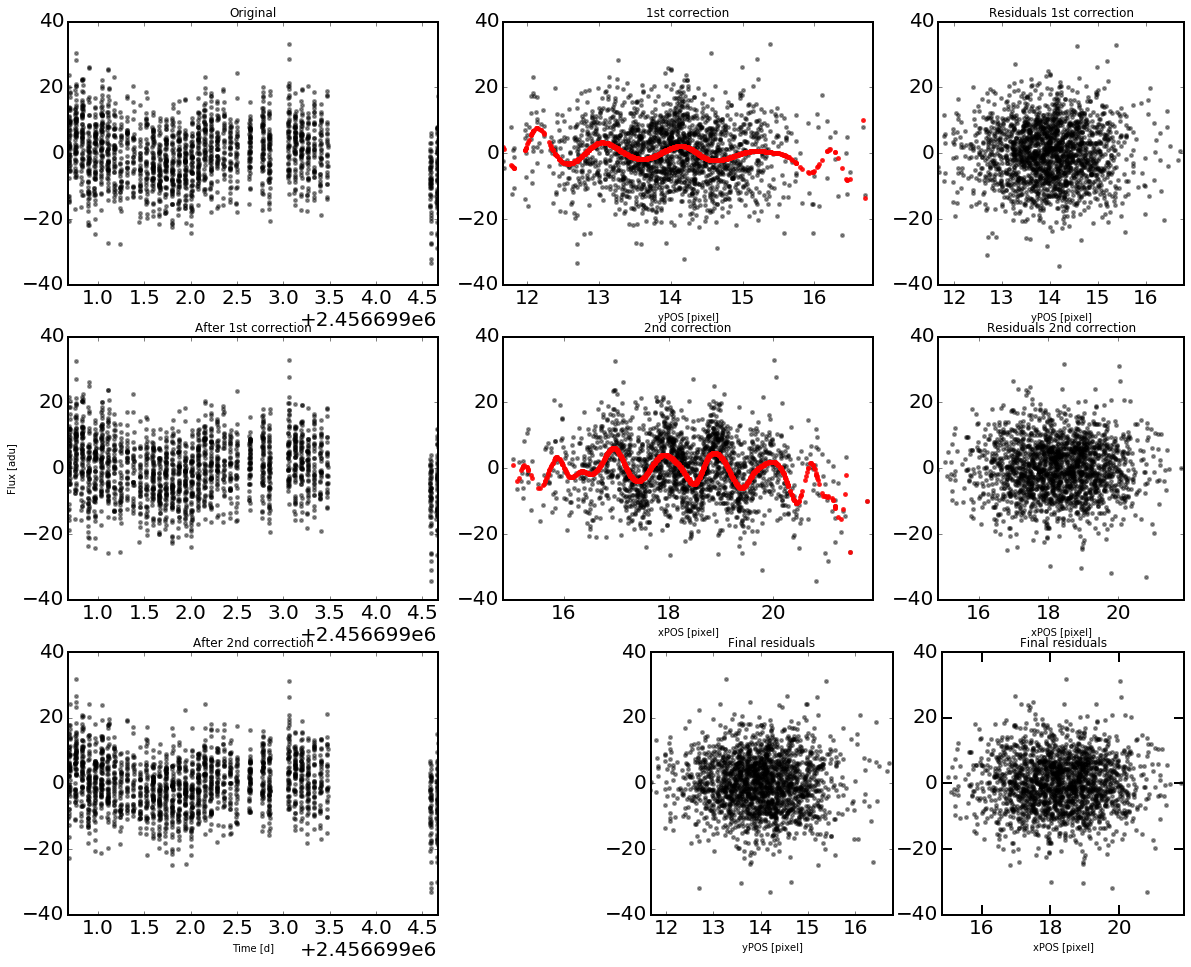

Minor debugging diagnostics provided for your convenience
1 - knotpoint spacing = 0.30; phaseshift spacing = 0.23
2 - knotpoint spacing = 0.22; phaseshift spacing = 0.03
THIS IS window 11


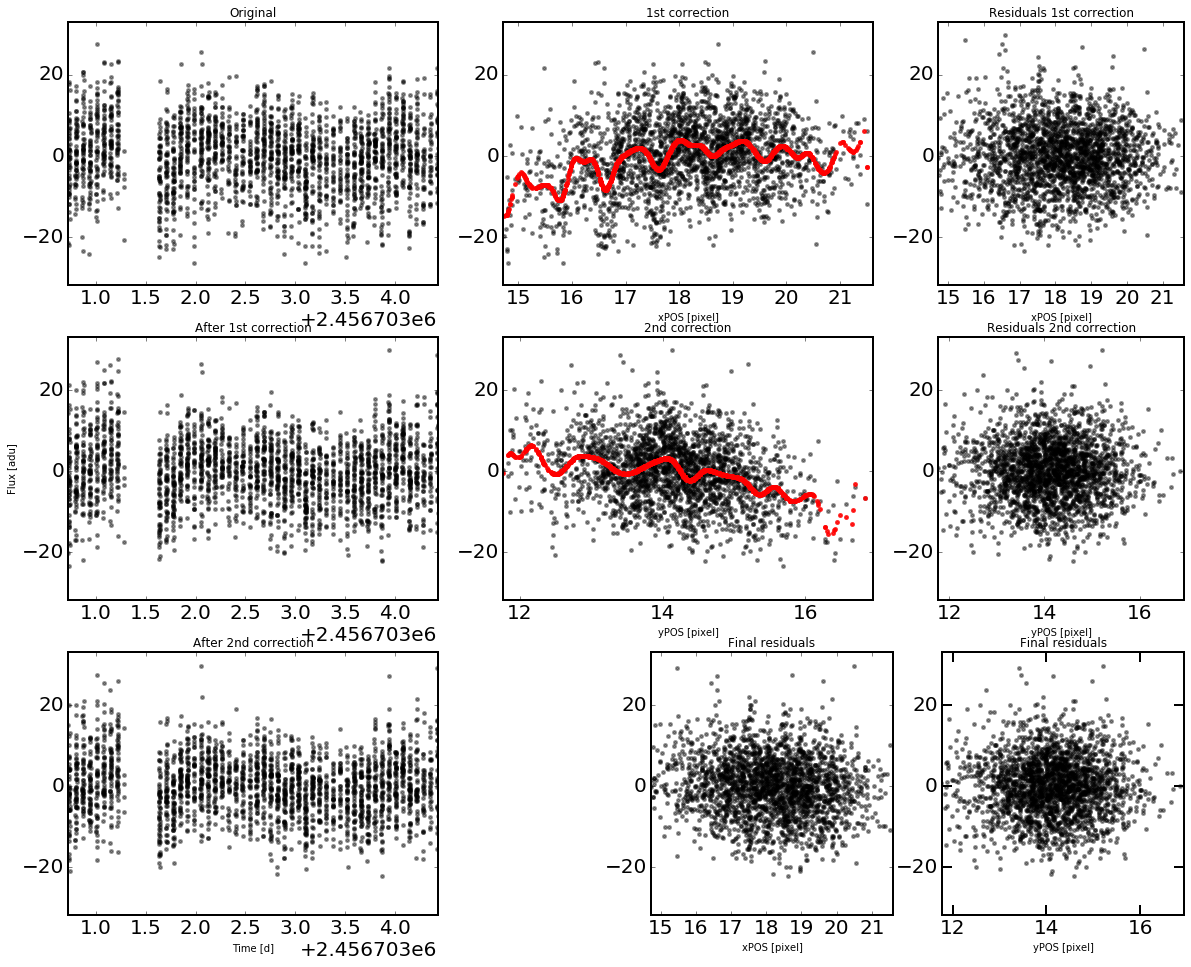

Minor debugging diagnostics provided for your convenience
1 - knotpoint spacing = 0.20; phaseshift spacing = 0.19
2 - knotpoint spacing = 0.20; phaseshift spacing = 0.09
THIS IS window 12


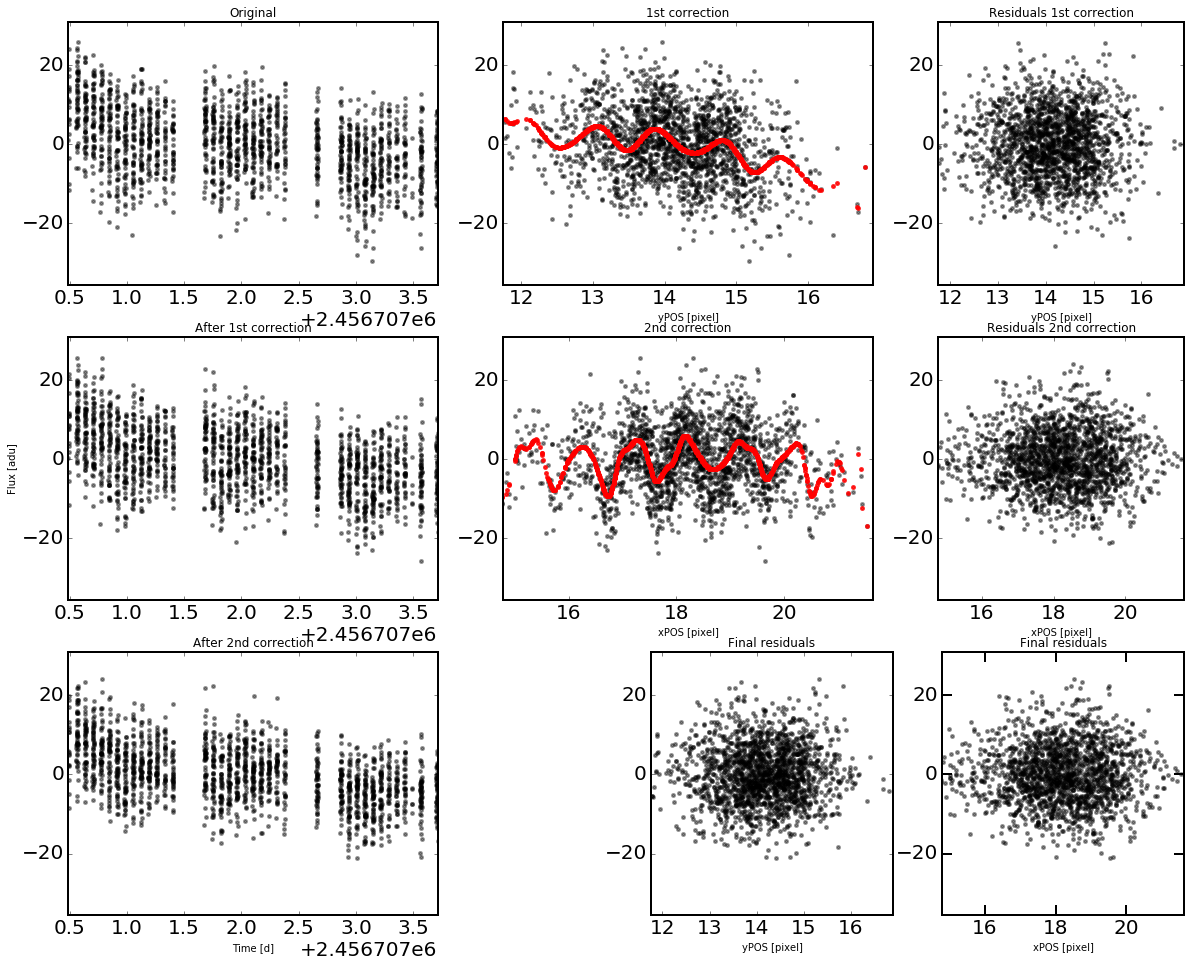

Minor debugging diagnostics provided for your convenience
1 - knotpoint spacing = 0.35; phaseshift spacing = 0.07
2 - knotpoint spacing = 0.17; phaseshift spacing = 0.04
THIS IS window 13


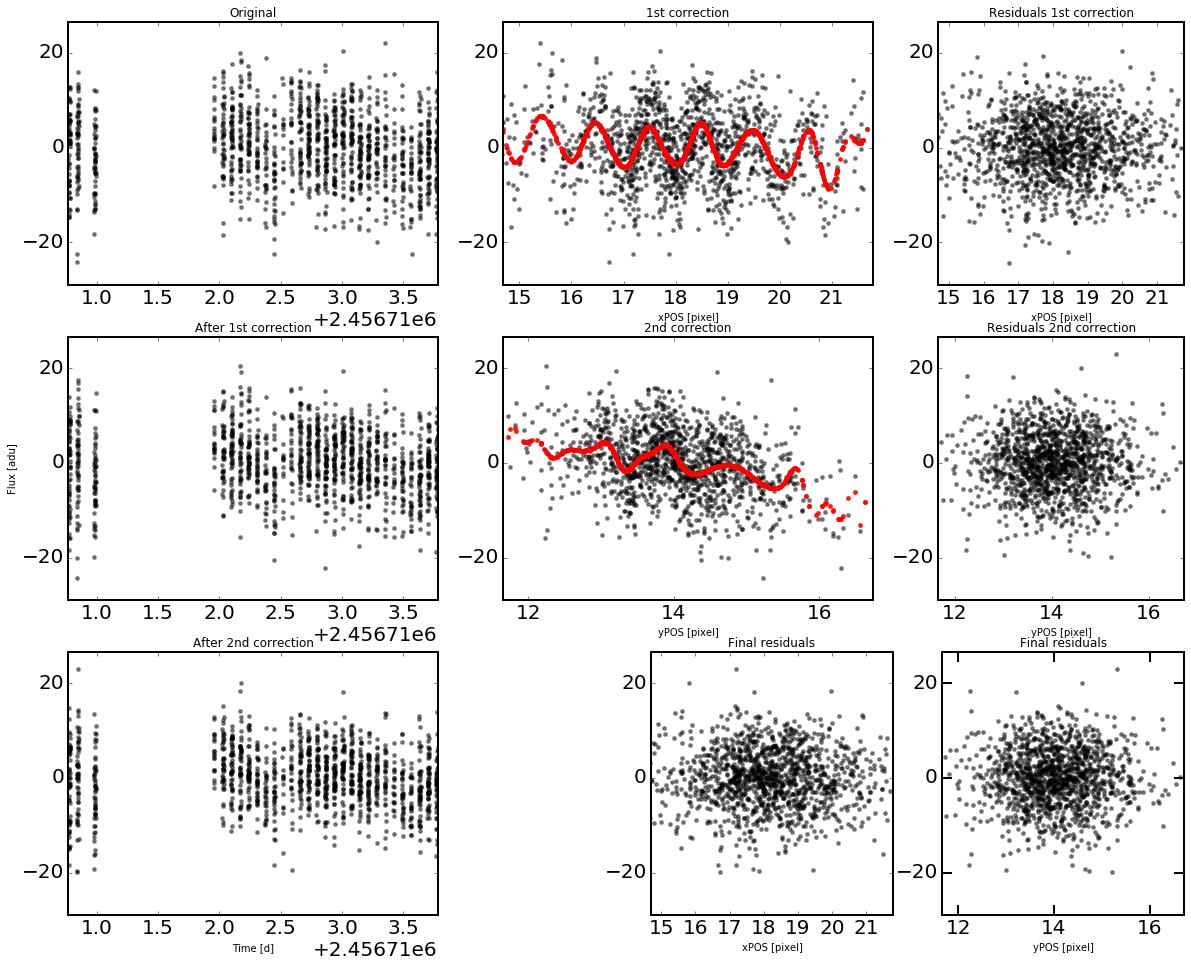

Minor debugging diagnostics provided for your convenience
1 - knotpoint spacing = 0.35; phaseshift spacing = 0.06
2 - knotpoint spacing = 0.20; phaseshift spacing = 0.15
THIS IS window 14


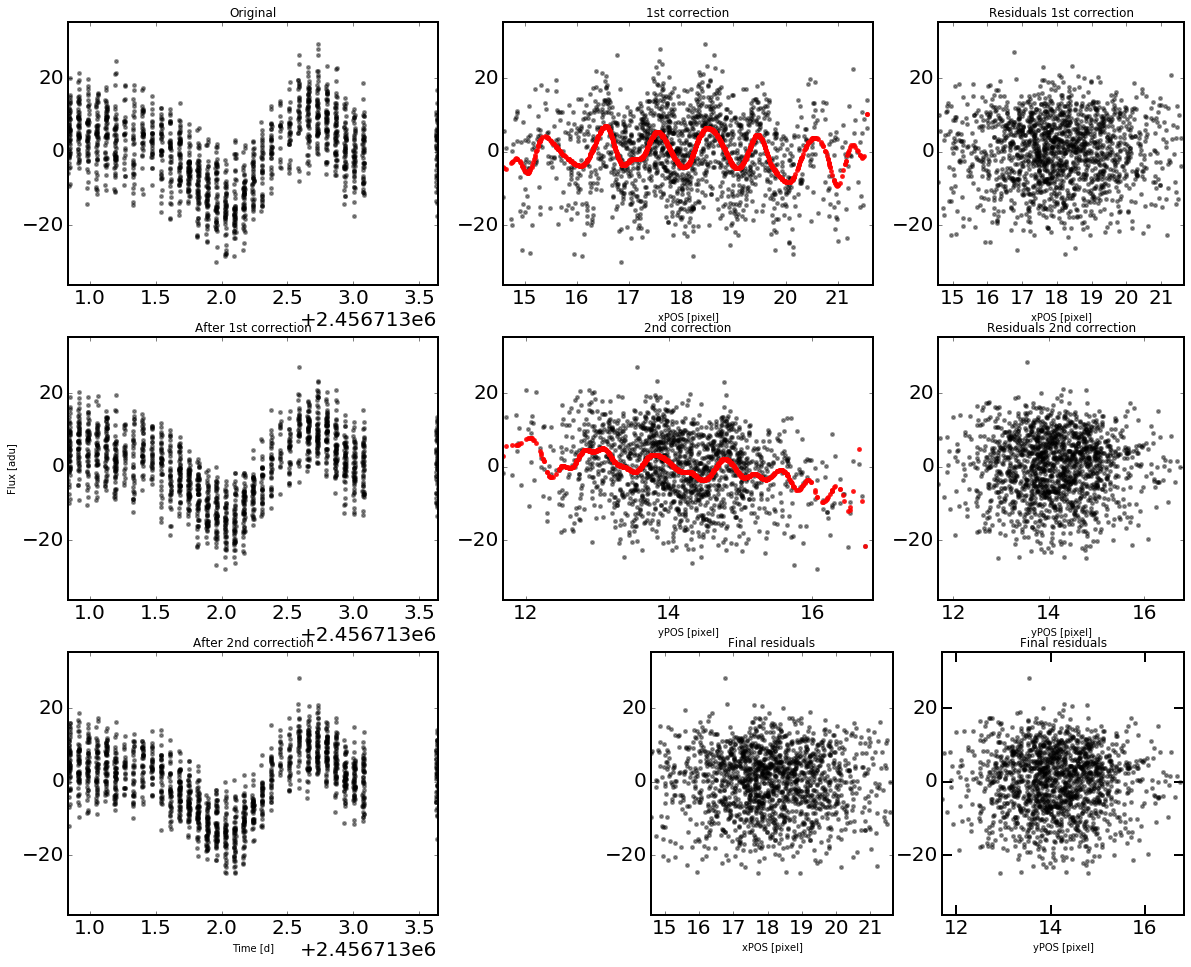

Minor debugging diagnostics provided for your convenience
1 - knotpoint spacing = 0.22; phaseshift spacing = 0.14
2 - knotpoint spacing = 0.15; phaseshift spacing = 0.01
THIS IS window 15


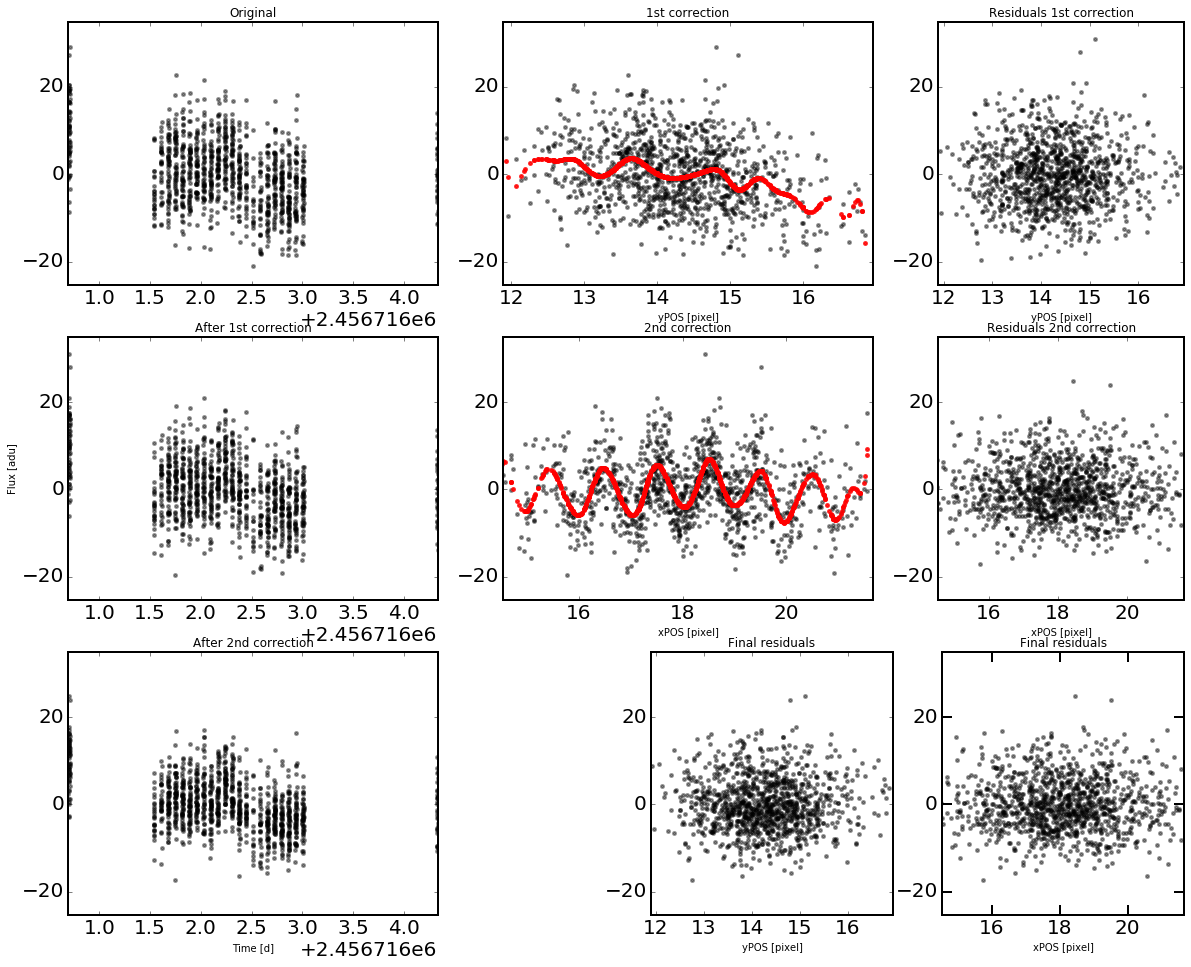

Minor debugging diagnostics provided for your convenience
1 - knotpoint spacing = 0.25; phaseshift spacing = 0.08
2 - knotpoint spacing = 0.35; phaseshift spacing = 0.22
THIS IS window 16


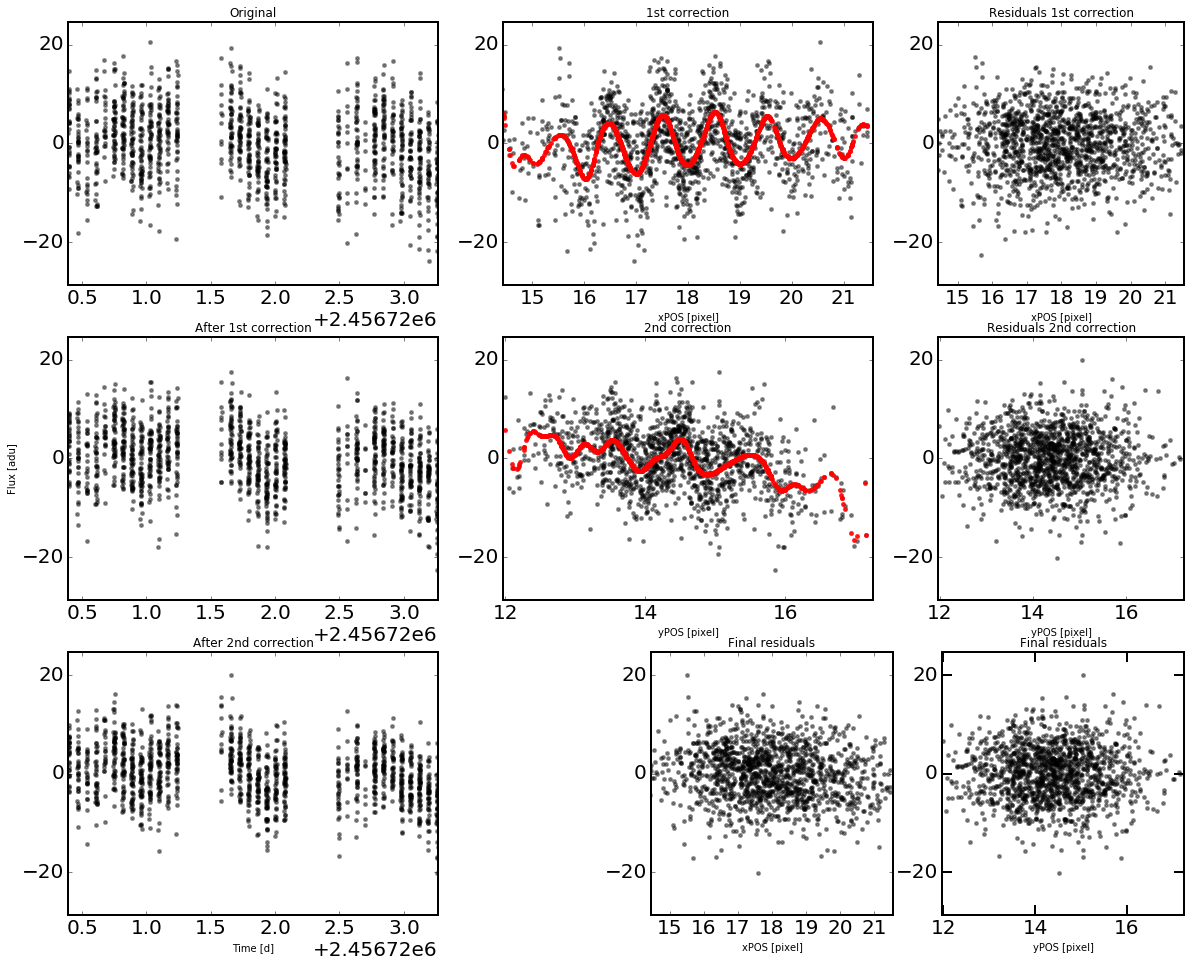

Minor debugging diagnostics provided for your convenience
1 - knotpoint spacing = 0.25; phaseshift spacing = 0.21
2 - knotpoint spacing = 0.20; phaseshift spacing = 0.05
THIS IS window 17


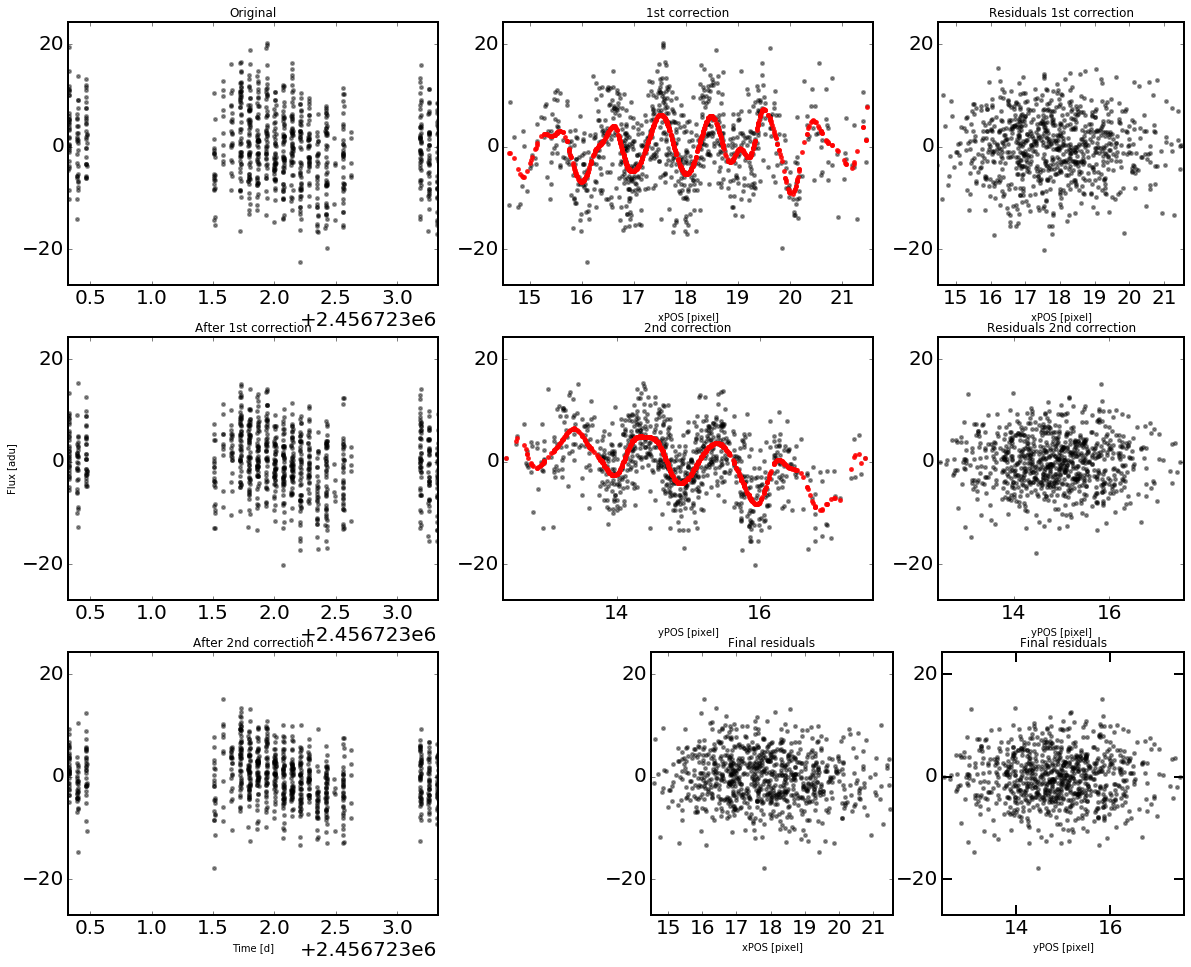

Minor debugging diagnostics provided for your convenience
1 - knotpoint spacing = 0.20; phaseshift spacing = 0.05
2 - knotpoint spacing = 0.20; phaseshift spacing = 0.08
THIS IS window 18


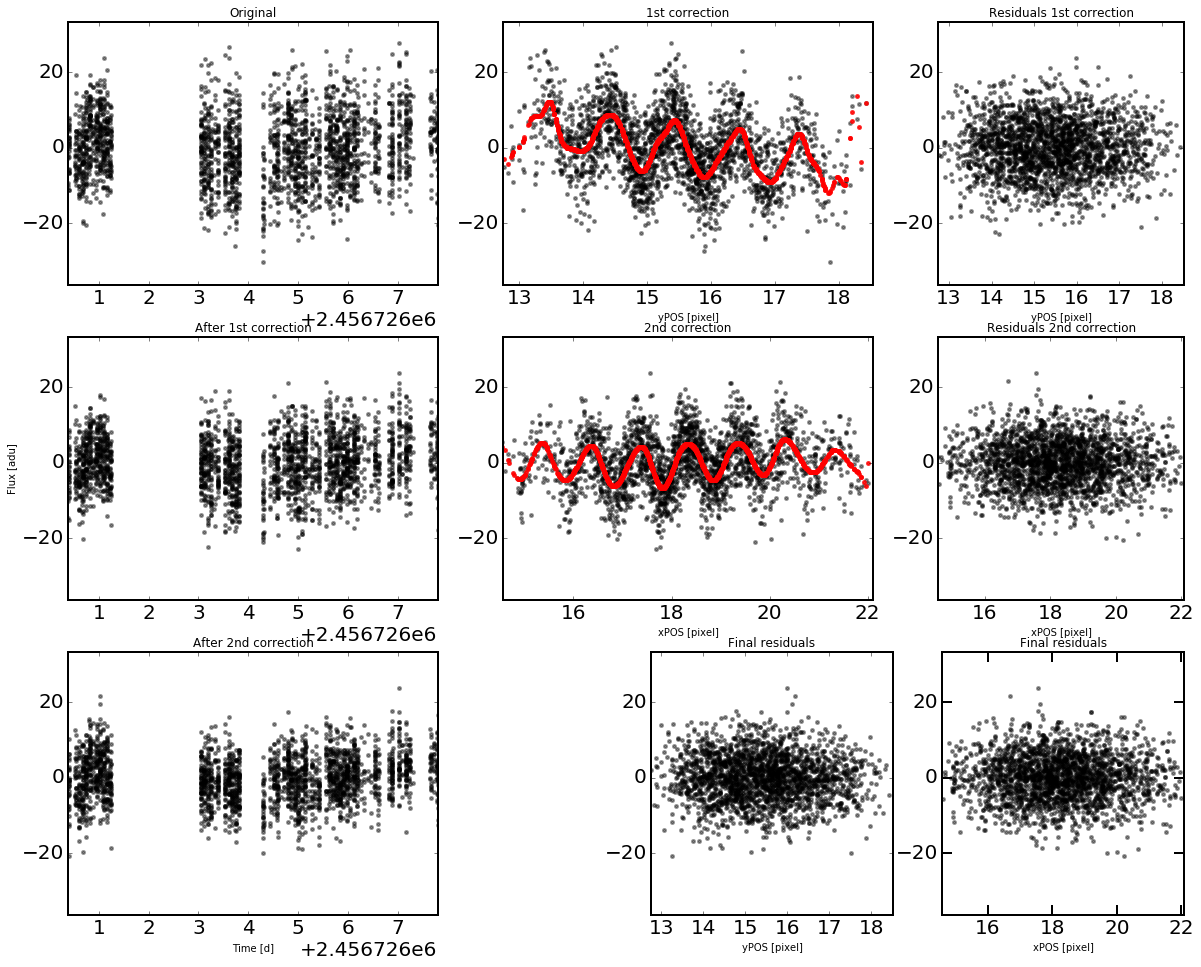

Minor debugging diagnostics provided for your convenience
1 - knotpoint spacing = 0.15; phaseshift spacing = 0.09
2 - knotpoint spacing = 0.35; phaseshift spacing = 0.18


In [32]:
for i in range(len(binENDindexes)):
    
    print('THIS IS window '+str(i))
    fin_ind = binENDindexes[i]+1 # ending index

    datachunk = data[init_ind:fin_ind]  #slice the array on the given indices
    HJD_bin = datachunk[:,columns['HJD']]
    FLUX_bin = datachunk[:,columns['FLUX']]
    xPOS_bin = datachunk[:,columns['XCEN']]
    yPOS_bin = datachunk[:,columns['YCEN']]
    
   
    
    # Manual edit by Bram Buysschaert (14/11/2016) to resolve a minor issue with some remaining outliers
    if i == 5:
        
        # You place the knotpoint spacing slightly larger, but only for this bin, otherwise, you are going to miss the variability in the proper bins
        SPLINEknotpointsSPACING = np.array([0.15, 0.17, 0.20, 0.22, 0.25, 0.3, 0.35, 0.40, 0.50])
    else:
        # reset the knotpoint spacing
        SPLINEknotpointsSPACING = np.array([0.15, 0.17, 0.20, 0.22, 0.25, 0.3, 0.35])
        

    # Apply FIT
    correction_bin, tckFIRSTstring_bin, tckSECONDstring_bin, diagnostic_bin = PSFdetrendBRITE.detrendTEMPpsfFULL(HJD_bin, FLUX_bin, xPOS_bin, yPOS_bin, show_ME=True, SPLINEknotpointsSPACING = SPLINEknotpointsSPACING, SPLINEorder = SPLINEorder, SPLINEstringLENGTH =  SPLINEstringLENGTH)
    np.mean(correction_bin)

    correction.append(correction_bin)
    tckFIRSTstring.append(tckFIRSTstring_bin)
    tckSECONDstring.append(tckSECONDstring_bin)
    diagnostic.append(diagnostic_bin)

    #now move init_index up to a different chunk

    init_ind =  binENDindexes[i]+1
# Now concatenate so that there is one array for each output

correction = np.concatenate(correction)

# finally apply the correction to the flux

flux_fitcorrected = FLUX - correction


Okay, so before we just sit we are fitting the data, but that function did A LOT. So let's discuss what is going on here and what it means so that if we actually need to change what's being done at some point in the future, you don't have to dive into the code to make sense of it. This function basically fits a bunch of spline functions and picks the best one based on two different information criteria: bayesian and akaike. You can provide the spline values for fitting like the knot spacing and the polynomial order and it will create hundreds of different combinations of these and find the one that best fits to the data. There is only one problem with this fitting procedure which is that it's prone to failure when the data clipping isn't rigorous enough. This is a large part of the reason for clipping outliers from several different parameters in the first tutorial.


Now let's plot the result and see how we did.


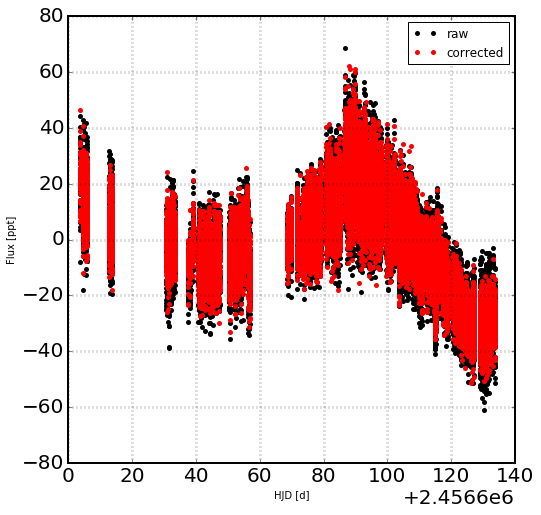

In [36]:
plt.figure(figsize=(8,8))
plt.plot(HJD, FLUX, 'k.', label='raw')
plt.plot(HJD, flux_fitcorrected, 'r.', label='corrected')
plt.legend()
plt.grid(color='k', lw=3, alpha=.25)
plt.xlabel('HJD [d]'); plt.ylabel('Flux [ppt]')
plt.show()


We did pretty good. Now let's add the intrapixel correction and see how it compares.

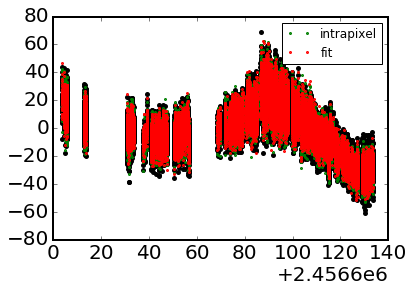

In [37]:
plt.figure(figsize=(8,8))
plt.plot(HJD, FLUX, 'k.')

plt.plot(HJD, flux_intcorrected, 'g.', ms=2., label='intrapixel')
plt.plot(HJD, flux_fitcorrected, 'r.', ms=2., label='fit')
plt.legend(prop={'size':12})
plt.show()


By Eye, these are surprisingly close with the fit looking a bit better. However, to really get a good idea we could have to calculate the rms error for each dataset. Fortunately there is a convenience function for this, so let's do that below.

In [38]:
err_int = be.data_err(HJD, flux_intcorrected, orbper)

err_fit = be.data_err(HJD, flux_fitcorrected, orbper)

print "Error Intrapixel", err_int

print "Error Fit", err_fit


Error Intrapixel 1.16406648092
Error Fit 1.11025072309



This shows us that the fit corrected is better, at least marginally. For now though, there is one very important thing to notice: the longterm trend in flux doesn't seem to be affected by this correction at all. So, what would happen if we removed it before doing all these things, say with a lowess filter. Now keep in mind this can be dangerous, but we won't lose the longterm trend, because we will add it back in at the end. This is entirely optional, but it gives us something interesting to try and it might make our corrections much better. 

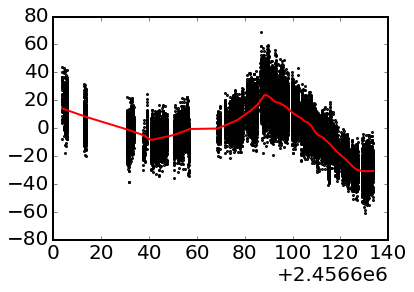

In [39]:
frac=0.1
FLUXlowess = sm.nonparametric.lowess(FLUX, HJD, frac=frac, delta=0.1)
time_l, FLUX_l = FLUXlowess[:,0], FLUXlowess[:,1]

plt.figure(figsize=(8,8))
plt.plot(HJD, FLUX, 'k.', markersize=2.0)
plt.plot(time_l, FLUX_l, 'r', lw=2.0)
plt.show()
FLUX_subtracted = FLUX-FLUX_l

Now let's see what difference it has, on the intrapixel correction.

ERROR Intrapixel Longterm trend subtracted 1.16292062783


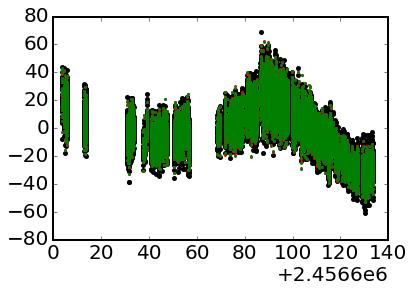

In [40]:
flux_intcorrected_subtracted = be.binnedINTRAPIXEL(FLUX_subtracted, xPOS, yPOS, binENDindexes, plot=show_ME)

flux_intcorrected_new = FLUX_l+flux_intcorrected_subtracted #add back the subtracted flux

plt.figure(figsize=(8,8))
plt.plot(HJD, FLUX, 'k.')
plt.plot(HJD, flux_intcorrected, 'r.', ms=2.0, label='New Correction')
plt.plot(HJD, flux_intcorrected_new, 'g.', ms=2.0, label='New Correction')

err_int_ls = be.data_err(HJD, flux_intcorrected_new, orbper)
print "ERROR Intrapixel Longterm trend subtracted", err_int_ls

plt.show()

So, maybe a little improvement, but not a ton. What happens when we do the same thing for our fitting routine.

In [41]:
init_ind = 0 # starting index

correction = [] # list to put corr
tckFIRSTstring = [] #list to 
tckSECONDstring = [] #
diagnostic = []  #
SPLINEstringLENGTH = 3000

datan = np.copy(data) #need to make a copy so that we don't replace the real data
datan[:,columns['FLUX']] = FLUX_subtracted #change the flux column
#SPLINEknotpointsSPACING = np.array([0.1, 0.2,0.25,1./3.])
for i in range(len(binENDindexes)):
#for i in range(3,len(binENDindexes)):
    print('THIS IS window '+str(i))
    fin_ind = binENDindexes[i]+1 # ending index

    datachunk = datan[init_ind:fin_ind]  #slice the array on the given indices
    HJD_bin = datachunk[:,columns['HJD']]
    FLUX_bin = datachunk[:,columns['FLUX']]
    xPOS_bin = datachunk[:,columns['XCEN']]
    yPOS_bin = datachunk[:,columns['YCEN']]
    
    # Manual edit by Bram Buysschaert (14/11/2016) to resolve a minor issue with some remaining outliers
    if i == 5:
        
        # You place the knotpoint spacing slightly larger, but only for this bin, otherwise, you are going to miss the variability in the proper bins
        SPLINEknotpointsSPACING = np.array([0.15, 0.17, 0.20, 0.22, 0.25, 0.3, 0.35, 0.40, 0.50])
    else:
        # reset the knotpoint spacing
        SPLINEknotpointsSPACING = np.array([0.15, 0.17, 0.20, 0.22, 0.25, 0.3, 0.35])
    
    # Apply FIT
    correction_bin, tckFIRSTstring_bin, tckSECONDstring_bin, diagnostic_bin = PSFdetrendBRITE.detrendTEMPpsfFULL(HJD_bin, FLUX_bin, xPOS_bin, yPOS_bin, show_ME=show_ME, SPLINEknotpointsSPACING = SPLINEknotpointsSPACING, SPLINEorder = SPLINEorder, SPLINEstringLENGTH =  SPLINEstringLENGTH)
#    correction_bin, tckFIRSTstring_bin, tckSECONDstring_bin, diagnostic_bin = PSFdetrendBRITE.detrendTEMPpsfFULL(HJD_bin, FLUX_bin, xPOS_bin, yPOS_bin, show_ME=True, SPLINEknotpointsSPACING = np.array([1.]), SPLINEorder = np.array([3,5], dtype='int32'), SPLINEstringLENGTH =  SPLINEstringLENGTH)

    correction.append(correction_bin)
    tckFIRSTstring.append(tckFIRSTstring_bin)
    tckSECONDstring.append(tckSECONDstring_bin)
    diagnostic.append(diagnostic_bin)

    #now move init_index up to a different chunk

    init_ind =  binENDindexes[i]+1
# Now concatenate so that there is one array for each output

ncorrection = np.concatenate(correction)
#tckFIRSTstring = np.concatenate(tckFIRSTstring)         
#tckSECONDstring = np.concatenate(tckSECONDstring)
#diagnostic = np.concatenate(diagnostic)

# finally apply the correction to the flux

flux_fitcorrectedn = FLUX - ncorrection


THIS IS i 0
Minor debugging diagnostics provided for your convenience
1 - knotpoint spacing = 0.30; phaseshift spacing = 0.28
2 - knotpoint spacing = 0.25; phaseshift spacing = 0.12
THIS IS i 1
Minor debugging diagnostics provided for your convenience
1 - knotpoint spacing = 0.15; phaseshift spacing = 0.04
2 - knotpoint spacing = 0.35; phaseshift spacing = 0.12
THIS IS i 2
Minor debugging diagnostics provided for your convenience
1 - knotpoint spacing = 0.35; phaseshift spacing = 0.34
2 - knotpoint spacing = 0.20; phaseshift spacing = 0.02
THIS IS i 3
Minor debugging diagnostics provided for your convenience
1 - knotpoint spacing = 0.35; phaseshift spacing = 0.01
2 - knotpoint spacing = 0.35; phaseshift spacing = 0.27
THIS IS i 4
Minor debugging diagnostics provided for your convenience
1 - knotpoint spacing = 0.22; phaseshift spacing = 0.09
2 - knotpoint spacing = 0.22; phaseshift spacing = 0.01
THIS IS i 5
Minor debugging diagnostics provided for your convenience
1 - knotpoint spacin

ERROR Fit longterm trend subtraction 1.10875811665


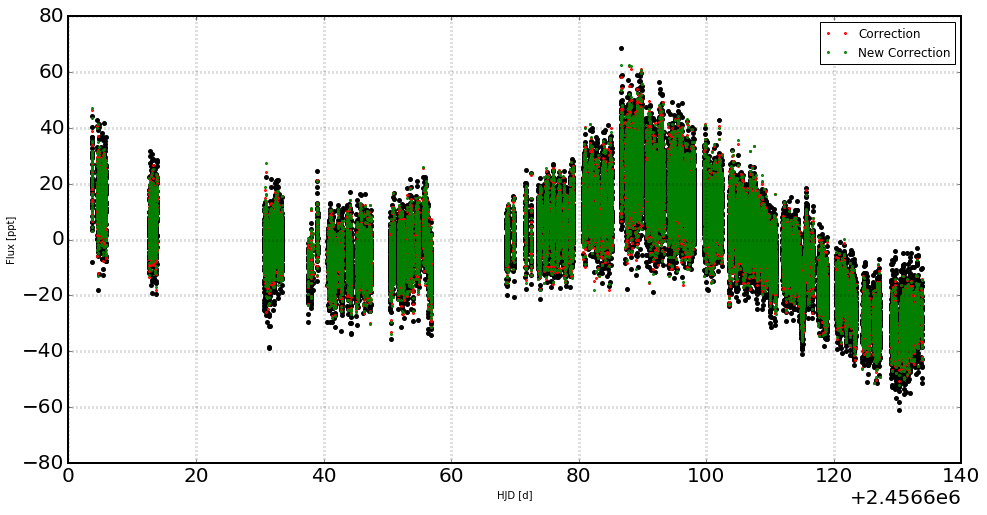

In [43]:
plt.figure(figsize=(16,8))
plt.plot(HJD, FLUX, 'k.')
plt.plot(HJD, flux_fitcorrected, 'r.', ms=2.0, label='Correction')
plt.plot(HJD, flux_fitcorrectedn, 'g.', ms=2.0, label='New Correction')
plt.legend()
plt.grid(color='k', lw=3, alpha=.25)
plt.xlabel('HJD [d]'); plt.ylabel('Flux [ppt]')

err_fit_ls = be.data_err(HJD, flux_fitcorrectedn, orbper)
print "ERROR Fit longterm trend subtraction", err_fit_ls
plt.show()



Again NOT a huge improvement, but your dataset might be different. This is giving you one more tool to try. It might help, or it might not but at least you are prepared. And now that we have done all of this let's save our file and move on to fitting. Oh, and you can choose what flux to take at this point. I will take flux fit corrected but not the trend subtracted as there is not a significant difference. Again, take NOTE of the correction so that you can refer to it later.

In [35]:
data[:,columns['FLUX']] = flux_fitcorrected #flux_intcorrected_new


params['flux_correction'] = 'spline fit' #other keywords could be 'intrapixel', 'detrended spline fit', 'detrended intrapixel'


And since we have our header dictionary let's use it, for no other reason than to get keywords for defining our filename. This is purely arbitrary, but it's kind of fun.

In [37]:
targ = params['StarInFo'].split(',')[0]
obsid= params['FieldIDn'].split('_')[1]
tel = params['SatellID']
setup = params['IFilSetN']

filename = str(targ)+'_'+str(obsid)+'_'+str(tel)+'_'+str(setup)+'_opsfrem.dat'

load.save_dataset(filename, data, columns=columns, params=params)

There is no column "FLAG" to delete
